<a href="https://colab.research.google.com/github/Mithunjha/ITK_ImageRegistration3D/blob/main/Registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import sys
!pip install itk
import itk 
from distutils.version import StrictVersion as VS
from ipywidgets import interactive, IntSlider
import matplotlib.pyplot as plt

     |████████████████████████████████| 54.5 MB 1.2 MB/s 
     |████████████████████████████████| 20.3 MB 1.1 MB/s 
     |████████████████████████████████| 95.3 MB 38 kB/s 
     |████████████████████████████████| 16.6 MB 39.2 MB/s 
     |████████████████████████████████| 15.0 MB 6.4 MB/s 
     |████████████████████████████████| 70.6 MB 8.1 kB/s 


In [3]:
!ls "/content/drive/MyDrive/Registration/"

difference_after.vtk   registered.vtk	      VF-MRT2-1014-1174.vtk
difference_before.vtk  VF-MRT1-1014-1174.vtk


In [4]:
if VS(itk.Version.GetITKVersion()) < VS("4.9.0"):
    print("ITK 4.9.0 is required.")
    sys.exit(1)

In [81]:
base = "/content/drive/MyDrive/Registration/"
fixedImageFile = base + "VF-MRT1-1014-1174.vtk"
movingImageFile = base + "VF-MRT2-1014-1174.vtk"
outputImageFile = base + "registered.vtk"
differenceImageAfterFile = base +  "difference_after.vtk"
differenceImageBeforeFile = base + "difference_before.vtk"

In [82]:
fixed_vis = itk.imread(fixedImageFile)
moving_vis = itk.imread(movingImageFile)

print("Choose the slice using slice selection slider")
select_slice = IntSlider(min=0, max=fixed_vis.shape[0]-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices
# set true for continuous_update

# Define a function for plotting images
def plot_slices(sliced):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title(f'Fixed Images : Slice {sliced}',fontsize = 20)
    ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title(f'Moving Images : Slice {sliced}',fontsize = 20)


# Use the interactive() tool to create the visualization
interactive(plot_slices , sliced=select_slice)

Choose the slice using slice selection slider


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=32), Output())…

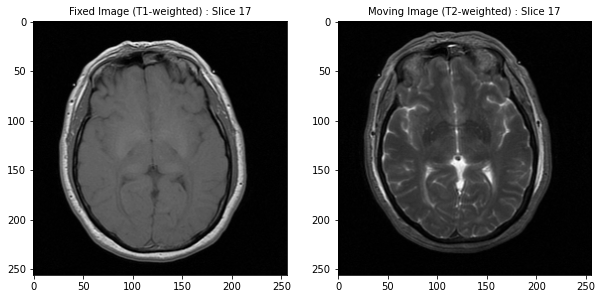

In [7]:
sliced = 17
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title(f'Fixed Image (T1-weighted) : Slice {sliced}',fontsize = 10);
ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title(f'Moving Image (T2-weighted) : Slice {sliced}',fontsize = 10);

### Metric : MattesMutualInformation ; Optimizier : GradientDescent; Transformation : Translation only ; Registration : Multi resolution

Shape of fixed image : (33, 256, 256)
Shape of moving image : (63, 256, 256)
Dimension : 3
ITKImageType of fixed image : <class 'itk.itkImagePython.itkImageF3'>
ITKImageType of moving image : <class 'itk.itkImagePython.itkImageF3'>
==========================Starting registration==========================
Index : 0 -->  Metric : -0.363855   (X,Y,Z) : (0.256409 -3.813188 -1.180615)
Index : 1 -->  Metric : -0.470647   (X,Y,Z) : (0.366235 -7.714076 -2.058688)
Index : 2 -->  Metric : -0.628557   (X,Y,Z) : (-1.687360 -11.044031 -1.225537)
Index : 3 -->  Metric : -0.537375   (X,Y,Z) : (-0.179787 -9.731233 -1.164040)
Index : 4 -->  Metric : -0.609955   (X,Y,Z) : (0.170345 -7.762874 -1.109538)
Index : 5 -->  Metric : -0.632928   (X,Y,Z) : (0.065918 -8.747871 -1.246928)
Index : 6 -->  Metric : -0.641698   (X,Y,Z) : (0.084300 -8.248325 -1.257681)
Index : 7 -->  Metric : -0.646847   (X,Y,Z) : (0.126899 -8.487026 -1.318566)
Index : 8 -->  Metric : -0.645818   (X,Y,Z) : (0.088192 -8.368174 -1.319516

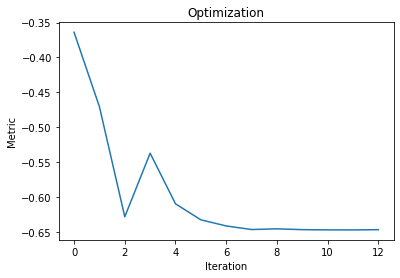

In [79]:
PixelType = itk.F

fixedImage = itk.imread(fixedImageFile, PixelType)
movingImage = itk.imread(movingImageFile, PixelType)

Dimension = fixedImage.GetImageDimension() 

FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]


print(f"Shape of fixed image : {fixedImage.shape}")
print(f"Shape of moving image : {movingImage.shape}")
print(f"Dimension : {Dimension}")
print(f"ITKImageType of fixed image : {FixedImageType}")
print(f"ITKImageType of moving image : {MovingImageType}")

###############################################################################################
############### Initialize the main components of ITK frame work ##############################
###############################################################################################

TransformType = itk.TranslationTransform[itk.D, Dimension] # translation transformation
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(LearningRate=4,         #Gradient descent
                                                          MinimumStepLength=0.001,
                                                          RelaxationFactor=0.5,
                                                          NumberOfIterations=100)


# can choose between 2 metrics - mutual information metric is more viable for this task
# to enable MSE uncomment below code

# metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

# comment below code to enable MSE error
metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New() #Mutual information as metric
numberOfBins = 24
metric.SetNumberOfHistogramBins(numberOfBins)
metric.SetUseMovingImageGradientFilter(False)
metric.SetUseFixedImageGradientFilter(False)

registration = itk.ImageRegistrationMethodv4[FixedImageType,MovingImageType].New(FixedImage=fixedImage,
                                                                                 MovingImage=movingImage,
                                                                                 Metric=metric,
                                                                                 Optimizer=optimizer,
                                                                                 InitialTransform=initialTransform)

movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0  # identity matrix is set as initial transofrmation for both fixed an moving image
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)
registration.SetMovingInitialTransform(movingInitialTransform)

identityTransform = TransformType.New()
identityTransform.SetIdentity()
registration.SetFixedInitialTransform(identityTransform)


## Enable multi scale registration by modifying below codes
registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0]) 
registration.SetShrinkFactorsPerLevel([1])

## example : (uncomment below section to enable multi scale registration)

# registration.SetNumberOfLevels(3)
# registration.SetSmoothingSigmasPerLevel([0,0,0]) #smoothing factor per level
# registration.SetShrinkFactorsPerLevel([1,2,3]) #shrink factor per level


## enable the observer to trace the intermediate optimizer values

iter = []
value = []
def iterationUpdate():
    currentParameter = registration.GetTransform().GetParameters()
    iter.append(optimizer.GetCurrentIteration())
    value.append(optimizer.GetValue())
    print(
        "Index : %i -->  Metric : %f   (X,Y,Z) : (%f %f %f)"
        % (
            optimizer.GetCurrentIteration(),
            optimizer.GetValue(),
            currentParameter.GetElement(0),
            currentParameter.GetElement(1),
            currentParameter.GetElement(2),

        )
    )
    

iterationCommand = itk.PyCommand.New()
iterationCommand.SetCommandCallable(iterationUpdate)
optimizer.AddObserver(itk.IterationEvent(), iterationCommand)

print("==========================Starting registration==========================")

registration.Update()

############ set translation parameters ##################
transform = registration.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)
translationAlongZ = finalParameters.GetElement(2)

########### get final parameters ######################
numberOfIterations = optimizer.GetCurrentIteration()
bestValue = optimizer.GetValue()

print("============================Registration done============================")
print("============================Final parameters=============================")
print("Result = ")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Translation Z = " + str(translationAlongZ))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))
print("=========================================================================")

######## set composite transformation #############
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

####### set resampler parameters ##############
resampler = itk.ResampleImageFilter.New(Input=movingImage,
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=fixedImage)

region = fixedImage.GetLargestPossibleRegion()
resampler.SetSize(region.GetSize())
resampler.SetOutputOrigin(fixedImage.GetOrigin())
resampler.SetOutputSpacing(fixedImage.GetSpacing())
resampler.SetOutputDirection(fixedImage.GetDirection())
resampler.SetDefaultPixelValue(100)

######################## write the output ####################################
OutputPixelType = itk.F
OutputImageType = itk.Image[OutputPixelType, Dimension]

writer = itk.ImageFileWriter.New(Input=resampler, FileName=outputImageFile)
writer.SetFileName(outputImageFile)
writer.Update()

out_vis = resampler.GetOutput()


###############################################################################
########################### get the difference image ##########################
###############################################################################

difference = itk.SubtractImageFilter.New(Input1=fixedImage,Input2=resampler) #get the difference image

intensityRescaler = itk.RescaleIntensityImageFilter[FixedImageType,OutputImageType].New( #rescale the intensity
            Input=difference,
            OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())


after_vis = intensityRescaler.GetOutput() # Get output for plotting
resampler.SetDefaultPixelValue(1) # set default pixel value - set to 100 to see effect of translation

############ write the output #####################
writer.SetInput(intensityRescaler.GetOutput())
writer.SetFileName(differenceImageAfterFile)
writer.Update()

########### resampler params #########################
resampler2 = itk.ResampleImageFilter.New(Input=movingImage,Transform=identityTransform,UseReferenceImage=True,ReferenceImage=fixedImage)
difference2 = itk.SubtractImageFilter.New(Input1=fixedImage,Input2=resampler2)
intensityRescaler2 = itk.RescaleIntensityImageFilter[FixedImageType,OutputImageType].New(
            Input=difference2,
            OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())

before_vis = intensityRescaler2.GetOutput()
writer.SetInput(intensityRescaler2.GetOutput())
writer.SetFileName(differenceImageBeforeFile)
writer.Update()

## plot the optimization plot
plt.plot(iter,value)
plt.title("Optimization");
plt.xlabel("Iteration");
plt.ylabel("Metric");

### Visualization

In [16]:
print("Choose the slice using slice selection slider")
select_slice = IntSlider(min=0, max=fixed_vis.shape[0]-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices # set true for continuous_update

# Define a function for plotting images
def plot_slices(sliced):
    fig, ax = plt.subplots(1,5, figsize=(50,25))
    ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title('Fixed Images',fontsize = 30)
    ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title('Moving Images',fontsize = 30)
    ax[2].imshow(out_vis[sliced], cmap='gray'), ax[2].set_title('Output Images',fontsize = 30)
    ax[3].imshow(before_vis[sliced], cmap='gray'), ax[3].set_title('Difference Before Registration Images',fontsize = 30)
    ax[4].imshow(after_vis[sliced], cmap='gray'), ax[4].set_title('Difference After Registration Images',fontsize = 30)


# Use the interactive() tool to create the visualization
interactive(plot_slices , sliced=select_slice)

Choose the slice using slice selection slider


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=32), Output())…

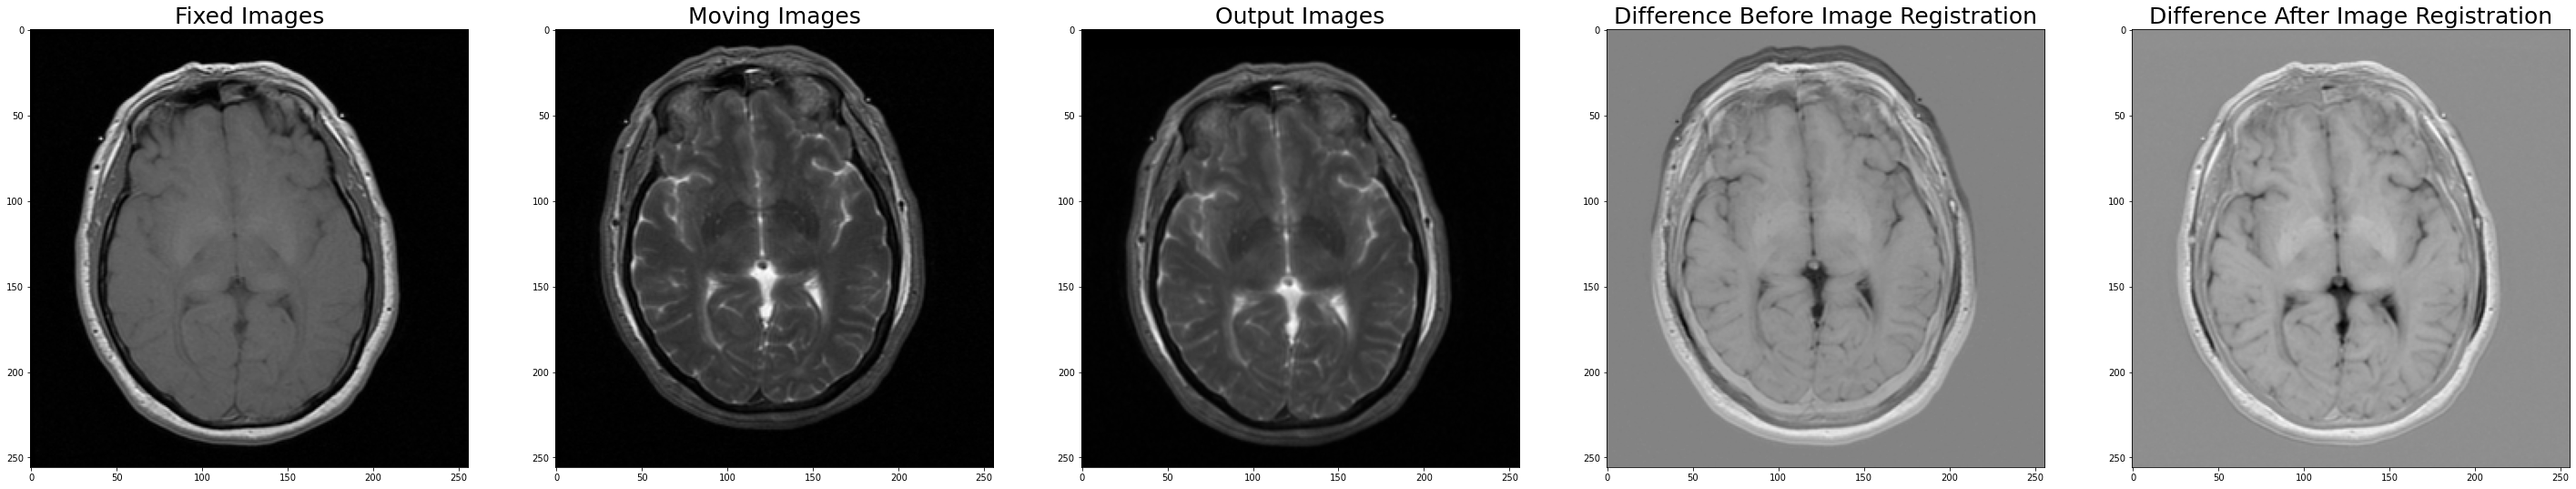

In [83]:
sliced = 17
fig, ax = plt.subplots(1,5, figsize=(50,25))
ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title('Fixed Images',fontsize = 25)
ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title('Moving Images',fontsize = 25)
ax[2].imshow(out_vis[sliced], cmap='gray'), ax[2].set_title('Output Images',fontsize = 25);
ax[3].imshow(before_vis[sliced], cmap='gray'), ax[3].set_title('Difference Before Image Registration',fontsize = 25);
ax[4].imshow(after_vis[sliced], cmap='gray'), ax[4].set_title('Difference After Image Registration',fontsize = 25);

In [92]:
def get_merged_img(fixed, image2, grids):
  fixed_copy = fixed.copy()
  moving_copy = image2.copy()

  size_x = fixed_copy.shape[-1]//grids
  # print(size_x)

  for i in range (0,grids):
    for j in range(0,grids):
      if (i+j)%2==1:
        # print(i+j)
        fixed_copy[i*size_x:(i+1)*size_x,j*size_x:(j+1)*size_x] = moving_copy[i*size_x:(i+1)*size_x,j*size_x:(j+1)*size_x]

  return fixed_copy



In [95]:
print("Choose the slice using slice selection slider")
select_slice = IntSlider(min=0, max=fixed_vis.shape[0]-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices # set true for continuous_update

# Define a function for plotting images
def plot_slices(sliced):
    before = get_merged_img(fixed_vis[sliced], moving_vis[sliced], grids=4)
    after = get_merged_img(fixed_vis[sliced], out_vis[sliced], grids=4)
    fig, ax = plt.subplots(1,5, figsize=(50,25))
    ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title('Fixed Images',fontsize = 30)
    ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title('Moving Images',fontsize = 30)
    ax[2].imshow(out_vis[sliced], cmap='gray'), ax[2].set_title('Output Images',fontsize = 30)
    ax[3].imshow(before, cmap='gray'), ax[3].set_title('Before Registration',fontsize = 30)
    ax[4].imshow(after, cmap='gray'), ax[4].set_title('After Registration',fontsize = 30)


# Use the interactive() tool to create the visualization
interactive(plot_slices , sliced=select_slice)

Choose the slice using slice selection slider


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=32), Output())…

(<matplotlib.image.AxesImage at 0x7f6f27a42b90>,
 Text(0.5, 1.0, 'After Image Registration'))

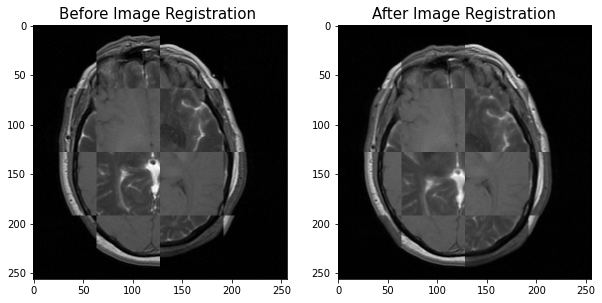

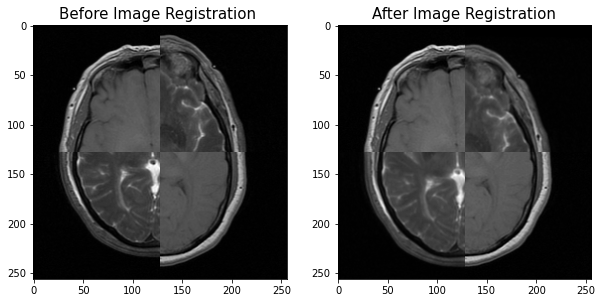

In [93]:
sliced = 17

before = get_merged_img(fixed_vis[sliced], moving_vis[sliced], grids=4)
after = get_merged_img(fixed_vis[sliced], out_vis[sliced], grids=4)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(before, cmap='gray'), ax[0].set_title('Before Image Registration ',fontsize = 15)
ax[1].imshow(after, cmap='gray'), ax[1].set_title('After Image Registration',fontsize = 15)

befored = get_merged_img(fixed_vis[sliced], moving_vis[sliced], grids=2)
afterd = get_merged_img(fixed_vis[sliced], out_vis[sliced], grids=2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(befored, cmap='gray'), ax[0].set_title('Before Image Registration ',fontsize = 15);
ax[1].imshow(afterd, cmap='gray'), ax[1].set_title('After Image Registration',fontsize = 15);


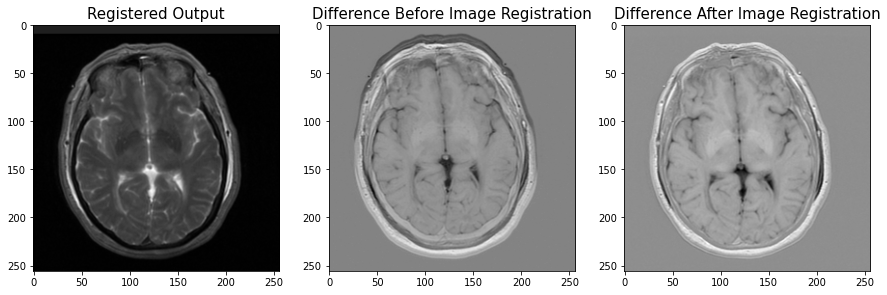

In [14]:
q = itk.imread("/content/drive/MyDrive/Registration/difference_after.vtk")
e = itk.imread("/content/drive/MyDrive/Registration/difference_before.vtk")
h = itk.imread("/content/drive/MyDrive/Registration/registered.vtk")

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[2].imshow(q[sliced], cmap='gray'), ax[2].set_title('Difference After Image Registration',fontsize = 15)
ax[1].imshow(e[sliced], cmap='gray'), ax[1].set_title('Difference Before Image Registration',fontsize = 15)
ax[0].imshow(h[sliced], cmap='gray'), ax[0].set_title('Registered Output',fontsize = 15);